In [12]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The relevant data set is collected in the subfolder "data". Note, that the data itself is not part of the repository and should be downloaded from  https://survey.stackoverflow.co/

In [22]:
df = pd.read_csv('./data/stack-overflow-developer-survey-2024/survey_results_public.csv')
print('total number of participants:', len(df))

# focus on professional developer, who provided information on their working tools
# df['TBranch'].value_counts(dropna=False)
prof_developers = df.loc[df['TBranch'] == 'Yes']
prof_developers = prof_developers.dropna(subset=['ProfessionalQuestion','ProfessionalTech'])
print('number of prof_developer:', len(prof_developers))



total number of participants: 65437
number of prof_developer: 27643


Question 1: Why is the percentage of professional developer who first try to solve a problem with AI search tools so low? Is there a bias, i.e. no AI search tools available at workplace?

Consider the variable 'PrefessionalQuestion', which refers to the question: "When you have a technical question at work, where do you first go to get an answer?"

In [14]:
# shorter descriptions for plotting
dic_rename_PQ = {
    'Do search of internal share drives/storage locations for documentation (i.e., not a structured knowledge base)' : 'internal unstructured knowledge base'
}
prof_developers['ProfessionalQuestion'] = prof_developers['ProfessionalQuestion'].replace(dic_rename_PQ)

prof_developers['ProfessionalQuestion'].value_counts()

ProfessionalQuestion
Traditional public search engine        15166
A coworker                               5100
AI-powered search (free)                 2120
AI-powered search (paid)                 1889
Slack search                             1024
internal unstructured knowledge base      900
Internal Developer portal                 759
Other:                                    544
Microsoft Teams search                    141
Name: count, dtype: int64

In [15]:
def check_for_AITool(df):
    assert 'ProfessionalTech' in df.columns, "Error: 'ProfessionalTech' column not found"
    df['AIToolsAvailable'] = df['ProfessionalTech'].apply(lambda x: 'AI-assisted technology tool' in x)


check_for_AITool(prof_developers)
prof_developers['AIToolsAvailable'].value_counts()

AIToolsAvailable
False    18684
True      8959
Name: count, dtype: int64

Text(0, 0.5, '')

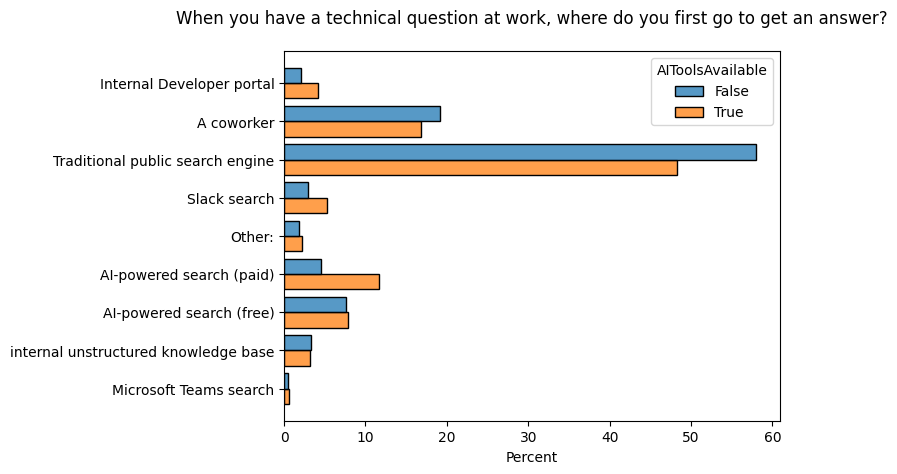

In [16]:
# create visualization
# note, the plot shows the percentages with respect to the subgroups AIToolsAvailable
# AIToolsAvailable=True accounts only for approximately 1/3 of professional developers
sns.histplot(data=prof_developers, y='ProfessionalQuestion', stat="percent", hue='AIToolsAvailable', multiple='dodge',common_norm=False, shrink=0.8)
plt.title('When you have a technical question at work, where do you first go to get an answer?',pad=20)
plt.ylabel('')

Question 2b: Does the method of choice depend on the age? 

Text(0, 0.5, '')

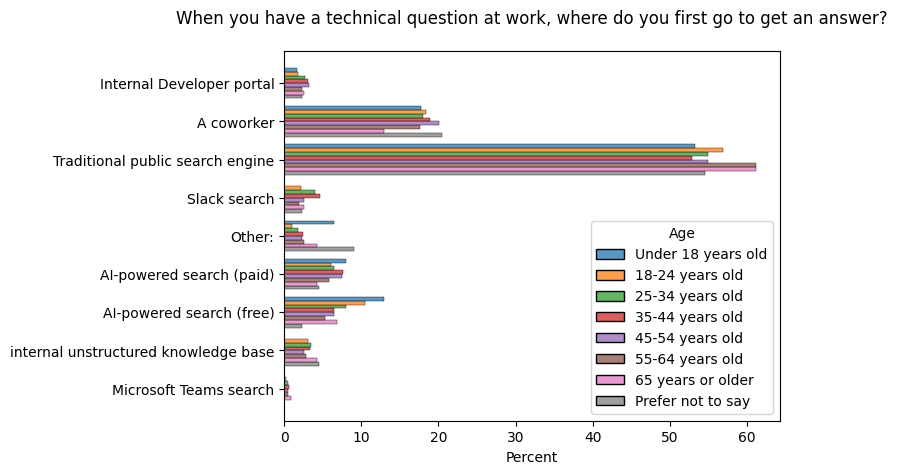

In [17]:

sns.histplot(data=prof_developers, y='ProfessionalQuestion', stat="percent", 
             hue='Age', multiple='dodge',common_norm=False, shrink=0.8,
             hue_order=['Under 18 years old', '18-24 years old', '25-34 years old',
            '35-44 years old', '45-54 years old', '55-64 years old', '65 years or older', 'Prefer not to say'])
plt.title('When you have a technical question at work, where do you first go to get an answer?',pad=20)
# plt.tight_layout()
plt.ylabel('')

In [18]:
prof_developers['Age'].value_counts()

Age
25-34 years old       12038
35-44 years old        7717
18-24 years old        3834
45-54 years old        2881
55-64 years old         951
65 years or older       116
Under 18 years old       62
Prefer not to say        44
Name: count, dtype: int64

Question 2: Which role play challenges associated with AI

Consider the variable 'AIChallenge', which refers to the question: "What are the challenges to your company/whole team using AI code assistants or GenAI tools? Select all that apply."

In [ ]:
prof_developers_q2 = prof_developers.copy().dropna(subset=['AIChallenges'])
print(f'number of professional developers who answered the question about AIChallenges:', len(prof_developers_q2))


One-hot encoding for column 'AIChallenges'

In [40]:

def one_hot_encoding_column(df,column_name):
    """
    Perform one-hot encoding on a specified column with multiple values 
    per cell (separated by ';') in a pandas DataFrame.

    Args:
    df (pandas.DataFrame): The input DataFrame.
    column_name (str): Name of the column to encode.

    Returns:
    unique_values: The function returns the unique values 
    and modifies the DataFrame in-place.
    """
    
    assert df[column_name].isna().sum() == 0, "Column contains NaN values"

    df[f'{column_name}_tmp'] = df[column_name].str.split(';')

    unique_values = set(sentence for sublist in df[f'{column_name}_tmp'] for sentence in sublist)
    #print(unique_values)

    for sentence in unique_values:
        df[sentence] = df[column_name].apply(lambda x: 1 if sentence in x else 0)

    del df[f'{column_name}_tmp']

    return unique_values


In [49]:
ai_challenges = one_hot_encoding_column(prof_developers_q2, 'AIChallenges')
#prof_developers_q2.head()
ai_challenges


{'AI tools lack context of codebase,  internal architecture, and/or company knowledge',
 'Don’t trust the output or answers',
 'Lack of executive buy-in',
 'Lack of proper training and education on new tools',
 'Not everyone uses them',
 'Other (please specify):',
 'They create more work (more code/PRs to review, etc.)',
 'We don’t have the right policies in place to reduce security risks'}

Group the answers to 'ProfessionalQuestion' with respect to their AI context

In [67]:
def type_of_first_contact_for_questions(df):    
    assert 'ProfessionalQuestion' in df.columns, "Error: 'ProfessionalQuestion' column not found"
    df['FirstContact'] = df['ProfessionalQuestion'].apply(lambda x: ('AI-powered search (paid)' in x or 'AI-powered search (free)' in x))
    df['FirstContact'] = df['FirstContact'].replace({True: 'AI_search_tool', False: 'NonAI_search_tool'})

type_of_first_contact_for_questions(prof_developers_q2)
prof_developers_q2['FirstContact'].value_counts()

FirstContact
NonAI_search_tool    15703
AI_search_tool        3611
Name: count, dtype: int64

Prepare heatmap that shows the number of professional developers who mentioned a specific AI concern, subdived in two groups depending on the usage of AI Search tools

In [113]:
#create a pivot table with the AI challenge as index and the first contact as columns
import pandas as pd
list_pivot_tables = []

for i in ai_challenges:

    df_tmp = prof_developers_q2[[i,'FirstContact','ResponseId']].groupby([i,'FirstContact']).count().reset_index()
    df_tmp = df_tmp.loc[df_tmp[i] == 1].copy()
    df_tmp[i] = df_tmp[i].replace({1: i})

    pivot_table = pd.pivot_table(df_tmp, 
                      values='ResponseId', 
                      index=[i], 
                      columns=['FirstContact'])

    pivot_table = pivot_table.astype(int)
    pivot_table_renamed = pivot_table.rename_axis('AI Challenge', axis='index')

    list_pivot_tables.append(pivot_table_renamed)

pivot_table_final = pd.concat(list_pivot_tables)



In [ ]:
sns.heatmap(pivot_table_final, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

<Axes: xlabel='Percentages', ylabel='AI Challenge'>

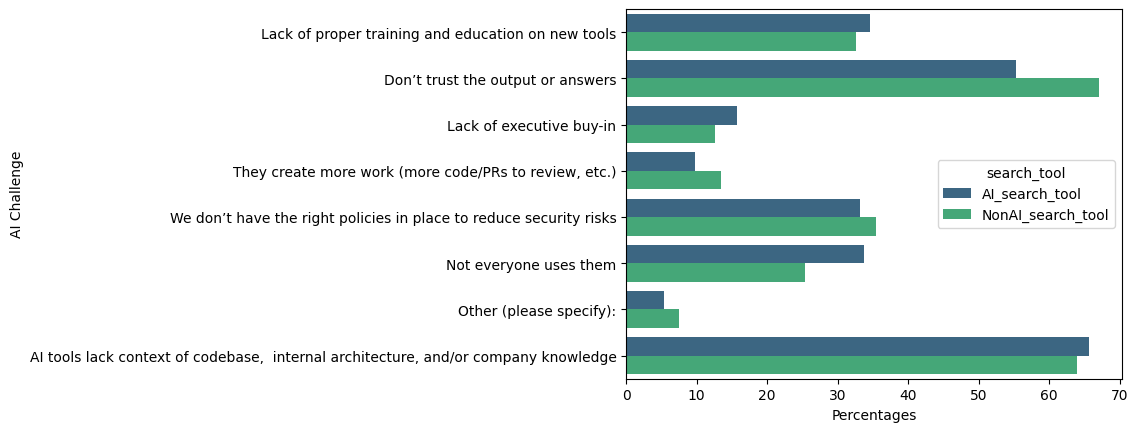

In [152]:

num_AI_search_tool = len(prof_developers_q2.loc[prof_developers_q2['FirstContact']=='AI_search_tool'])
num_NonAI_search_tool = len(prof_developers_q2.loc[prof_developers_q2['FirstContact']=='NonAI_search_tool'])

df1 = (pivot_table_final['AI_search_tool'] / num_AI_search_tool * 100).to_frame('Percentages')
df1['search_tool'] = 'AI_search_tool'
df2 = (pivot_table_final['NonAI_search_tool'] / num_NonAI_search_tool * 100).to_frame('Percentages')
df2['search_tool'] = 'NonAI_search_tool'

df_total = pd.concat([df1,df2]).reset_index()
df_total.head(10)

#df_total.columns
sns.barplot(x='Percentages', y='AI Challenge', data=df_total, hue='search_tool', palette='viridis')


Question 3: Can we use a simple logistic regression to identify factors with high influence

Prepare Data

In [136]:
# restrict dataframe
columns_of_interest =[]


In [137]:
X = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y = np.array([0, 0, 0, 1, 1, 1])

In [138]:


lr_model = LogisticRegression()
lr_model.fit(X, y)

LogisticRegression()

Make predictions

In [139]:
y_pred = lr_model.predict(X)

print("Prediction on training set:", y_pred)

Prediction on training set: [0 0 0 1 1 1]


Calculate accurancy

In [140]:
print("Accuracy on training set:", lr_model.score(X, y))

Accuracy on training set: 1.0
